# Importación de librerías y carga de datos

In [14]:
"""
# LA ÚLTIMA CELDA GUARDA EL MODELO ENTRENADO !!!!!!!!!

Modulo de entrenamiento para diferentes pipelines de ML para el
entrenamiento utilizando los datasets creados. El flujo es capaz de 
generalizar en la mayoría de los casos y únicamente es necesario
realizar modificaciones en la ruta a los datos.

"""
import os
import pandas as pd 
import seaborn as sns                                                   
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import numpy as np
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from xgboost import plot_importance
import pickle


path=r'C:\Users\santi\Desktop\Informatica_medica\Practicas\Final_project_ML\data'

In [2]:
data = pd.read_csv(os.path.join(path,'dataV1_NoAgrupados.csv'),sep=',')

In [3]:
data

,DESCRIPCION,Mes,Tipo Egreso (INTERNACION),Paciente Entidad Responsable Pago,Minutos (Camara - F3),Dx Principal Tipo,Paciente Edad,Paciente Sexo,Clasificacion 1 Triaje \r\nEnfermeria,Modalidad Atencion,...,B200,D509,Q210,H521,E160,S064,M546,T250,F29X,J450
0,1,2.634,0,48,26.633333,1,75.0,1,4,1,...,0,0,0,0,0,0,0,0,0,0
1,1,2.634,1,5,65.133333,0,61.0,1,3,1,...,0,0,0,0,0,0,0,0,0,0
2,1,2.634,1,65,82.050000,0,62.0,1,3,1,...,0,0,0,0,0,0,0,0,0,0
3,1,2.634,0,48,0.000000,0,78.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,2.634,0,1,116.850000,0,73.0,0,3,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28782,1,1.634,1,53,70.583333,0,23.0,0,3,1,...,0,0,0,0,0,0,0,0,0,0
28783,1,1.634,1,48,42.500000,0,49.0,1,4,1,...,0,0,0,0,0,0,0,0,0,0
28784,1,1.634,1,65,50.133333,0,43.0,0,3,1,...,0,0,0,0,0,0,0,0,0,0
28785,1,1.634,1,18,40.900000,0,54.0,0,3,1,...,0,0,0,0,0,0,0,0,0,0


In [4]:
print(f'sujetos: {data.shape[0]} | caracteristicas: {data.shape[1]}')

sujetos: 28787 | caracteristicas: 2430


# Preprocesamiento

In [5]:
# Se reorganiza la columna, para ponerla al final

target = data.pop('Tipo Egreso (INTERNACION)')
data.insert(len(data.columns), target.name, target)

### Creación de datasets de entrenamiento y test

In [6]:
X = data.values[:,:-1].astype(float)
y = data.values[:,-1].astype(float)
print(X.shape)
print(y.shape)

(28787, 2429)
(28787,)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(                            
    X, # Valores de X
    y, # Valores de Y
    test_size=0.1, # Test de 10% debido a que la validación cruzada se hace con el train set
    random_state=1, # Semilla
    stratify=data.values[:,-1]) # que se mantenga la proporcion en la división

In [8]:
print(f'tamaño del dataset de entrenamiento: {X_train.shape[0]}')
print(f'tamaño del dataset de test: {X_test.shape[0]}')


tamaño del dataset de entrenamiento: 25908
tamaño del dataset de test: 2879


### XGBoosting

In [9]:
# Definir los parámetros para la búsqueda aleatoria
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

param_dist = {
    'n_estimators': np.arange(50, 300, 50),
    'learning_rate': [0.0001, 0.001, 0.1, 0.2],
    'max_depth': np.arange(3, 30),
    'subsample': np.linspace(0.7, 1.0, 4),
    'colsample_bytree': np.linspace(0.7, 1.0, 4)
}

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xgb,
                                    param_distributions=param_dist,
                                    n_iter=10,
                                    cv=5,
                                    n_jobs=-1,
                                    verbose=5,
                                    random_state=42,
                                    return_train_score=True,
                                    scoring=['accuracy','precision'],
                                    refit='accuracy')

# Realizar la búsqueda
random_search.fit(X_train, y_train)

# Imprimir los mejores parámetros y la mejor puntuación
print("Mejores parámetros encontrados por RandomizedSearchCV:")
print(random_search.best_params_)
print("Mejor puntuación encontrada por RandomizedSearchCV:")
print(random_search.best_score_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Mejores parámetros encontrados por RandomizedSearchCV:
{'subsample': 0.9, 'n_estimators': 250, 'max_depth': 11, 'learning_rate': 0.1, 'colsample_bytree': 0.9}
Mejor puntuación encontrada por RandomizedSearchCV:
0.7918790348995837


In [10]:
results = pd.DataFrame(random_search.cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_n_estimators,param_max_depth,param_learning_rate,param_colsample_bytree,params,...,mean_test_precision,std_test_precision,rank_test_precision,split0_train_precision,split1_train_precision,split2_train_precision,split3_train_precision,split4_train_precision,mean_train_precision,std_train_precision
0,188.525275,1.979348,0.842750,0.141605,0.9,150,15,0.0010,1.0,"{'subsample': 0.9, 'n_estimators': 150, 'max_d...",...,0.726939,0.005934,5,0.818053,0.820312,0.819304,0.821363,0.822453,0.820297,0.001537
1,78.356860,1.519892,0.891537,0.122325,0.7,50,19,0.0010,0.7,"{'subsample': 0.7, 'n_estimators': 50, 'max_de...",...,0.646188,0.003580,8,0.672608,0.673345,0.674825,0.672185,0.676511,0.673895,0.001587
2,250.391489,9.398790,1.307566,0.241466,0.9,150,29,0.0010,0.9,"{'subsample': 0.9, 'n_estimators': 150, 'max_d...",...,0.721362,0.003508,6,0.846485,0.846969,0.849697,0.846983,0.844802,0.846987,0.001573
3,216.574354,4.695961,1.292288,0.251472,1.0,150,19,0.0010,0.9,"{'subsample': 1.0, 'n_estimators': 150, 'max_d...",...,0.719396,0.004867,7,0.833278,0.837434,0.837912,0.835489,0.830364,0.834895,0.002795
4,113.107702,2.685646,1.241302,0.230199,0.9,200,19,0.1000,0.9,"{'subsample': 0.9, 'n_estimators': 200, 'max_d...",...,0.775935,0.003722,2,0.964286,0.964055,0.967181,0.964450,0.960817,0.964158,0.002021
5,68.199966,1.542701,1.380593,0.384997,0.8,100,19,0.2000,0.9,"{'subsample': 0.7999999999999999, 'n_estimator...",...,0.769258,0.003994,4,0.976286,0.969994,0.975605,0.975684,0.966762,0.972866,0.003812
6,133.011953,2.561686,0.987975,0.086250,0.9,100,26,0.0001,0.7,"{'subsample': 0.9, 'n_estimators': 100, 'max_d...",...,0.511386,0.000061,9,0.511387,0.511387,0.511387,0.511362,0.511410,0.511386,0.000015
7,66.864566,4.207765,0.469338,0.064882,0.9,100,8,0.0001,0.9,"{'subsample': 0.9, 'n_estimators': 100, 'max_d...",...,0.511386,0.000061,9,0.511387,0.511387,0.511387,0.511362,0.511410,0.511386,0.000015
8,85.626041,0.755962,0.462464,0.109463,0.9,250,11,0.1000,0.9,"{'subsample': 0.9, 'n_estimators': 250, 'max_d...",...,0.780790,0.002591,1,0.886709,0.887908,0.887395,0.888879,0.889160,0.888010,0.000912
9,33.287141,3.250811,0.358276,0.097533,0.9,50,14,0.2000,1.0,"{'subsample': 0.9, 'n_estimators': 50, 'max_de...",...,0.770167,0.004180,3,0.895056,0.896357,0.900895,0.896276,0.888790,0.895475,0.003890


In [11]:
results[results['rank_test_accuracy']==1].T

,8
mean_fit_time,85.626041
std_fit_time,0.755962
mean_score_time,0.462464
std_score_time,0.109463
param_subsample,0.9
param_n_estimators,250
param_max_depth,11
param_learning_rate,0.1
param_colsample_bytree,0.9
params,"{'subsample': 0.9, 'n_estimators': 250, 'max_d..."


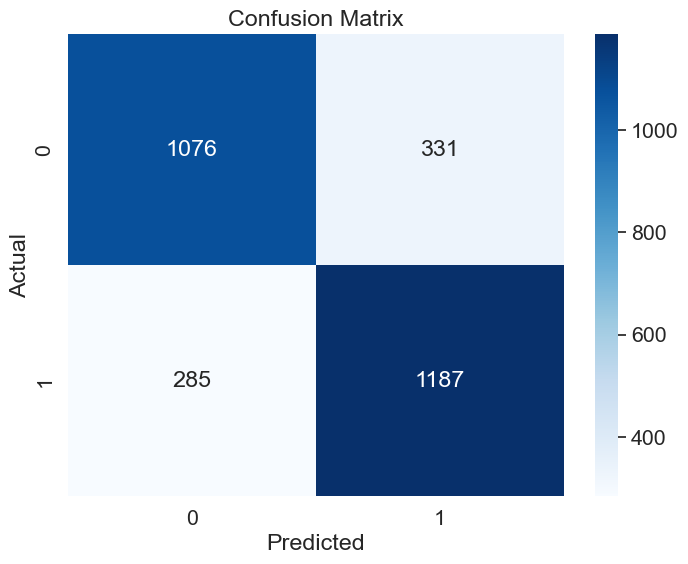

In [12]:
y_pred = random_search.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.4)  # Ajustar el tamaño de la fuente
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

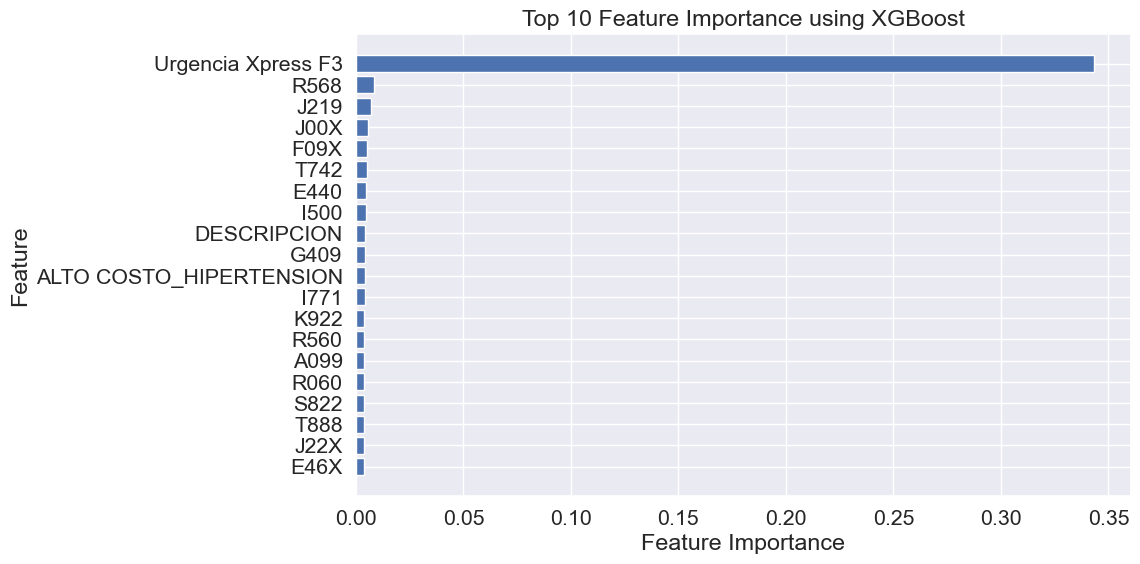

In [17]:
importances = random_search.best_estimator_.feature_importances_
feature_names = data.iloc[:, :-1].columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort by importance and get top 10
top_10 = importance_df.sort_values(by='Importance', ascending=False).head(20)

# Plot using a bar plot
plt.figure(figsize=(10, 6))
plt.barh(top_10['Feature'], top_10['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importance using XGBoost')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

In [18]:
# Nombre del directorio y del archivo
nombre_dir = 'models'
model_name = 'XGB_RSearchCV.pkl'

# Crear el directorio si no existe
if not os.path.exists(nombre_dir):
    os.makedirs(nombre_dir)

# Crear la ruta completa del archivo
path = os.path.join(nombre_dir, model_name)

# Guardar el DataFrame en formato CSV
pickle.dump(random_search.best_estimator_, open(path, 'wb'))